#  El Problema


Vamos a comenzar por los datos que nos proporciona una competición de DrivenData 

[Warm Up: Machine Learning with a Heart](https://www.drivendata.org/competitions/54/machine-learning-with-a-heart/)

El conjunto de datos es un clásico del aprendizaje automático. Procede de un estudio de enfermedades cardíacas realizado hace 30 años. 

El estudio, convenientemente anonimizado,  recoge varias mediciones sobre la salud de los pacientes y las estadísticas cardiovasculares.


En primer lugar vamos a estudiar el conjunto de entrenamiento (*train_values* y *train_labels*) que facilita la competición y que se puede encontrar en este [link](https://drive.google.com/drive/folders/1NfqnfLQqM-gJu5dh0hAhMURO-7_uDHdK?usp=sharing)

# Preparación


Antes de empezar cualquier análisis hay que asegurar que las librerías básicas y de uso general (numpy, pandas, etc.) están correctamente importadas. 

In [ ]:
# carga de datos
import pandas as pd
import io
from google.colab import files
# manipulación y visualización
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns



# Carga de Datos

En primer lugar cargamos los datos dentro del entorno con las funcionalidades que nos permite Google Colab

In [ ]:
def upload_files ():
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')))
    return df

En primer lugar subimos los datos de los pacientes de entrenamiento con sus características

In [ ]:
train_feat = upload_files()
train_feat.head()

Saving train_values.csv to train_values.csv
User uploaded file "train_values.csv" with length 9591 bytes


,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
0,0z64un,1,normal,128,2,0,0,2,308,0.0,1,45,170,0
1,ryoo3j,2,normal,110,3,0,0,0,214,1.6,0,54,158,0
2,yt1s1x,1,normal,125,4,3,0,2,304,0.0,1,77,162,1
3,l2xjde,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0
4,oyt4ek,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0


Posteriormente subimos los datos que únicamente nos proporcionan las "labels" de estos pacientes.

In [ ]:
train_labels = upload_files()
train_labels.head()

Saving train_labels.csv to train_labels.csv
User uploaded file "train_labels.csv" with length 1653 bytes


,patient_id,heart_disease_present
0,0z64un,0
1,ryoo3j,0
2,yt1s1x,1
3,l2xjde,1
4,oyt4ek,0


Mezclamos los dos conjuntos de datos para tenerlos en un único dataframe

In [ ]:
train = pd.merge(train_feat,train_labels,on='patient_id')

train.head()


,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present
0,0z64un,1,normal,128,2,0,0,2,308,0.0,1,45,170,0,0
1,ryoo3j,2,normal,110,3,0,0,0,214,1.6,0,54,158,0,0
2,yt1s1x,1,normal,125,4,3,0,2,304,0.0,1,77,162,1,1
3,l2xjde,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0,1
4,oyt4ek,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0,0


Finalmente subimos los datos de test para generar la evaluación final. 

In [ ]:
test = upload_files()
test.head()

Saving test_values.csv to test_values.csv
User uploaded file "test_values.csv" with length 4864 bytes


,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
0,olalu7,2,reversible_defect,170,1,0,0,2,288,0.2,1,59,159,0
1,z9n6mx,1,normal,138,4,0,0,0,183,1.4,0,35,182,0
2,5k4413,2,reversible_defect,120,4,0,0,2,177,2.5,1,43,120,1
3,mrg7q5,1,normal,102,3,1,0,0,318,0.0,0,60,160,0
4,uki4do,2,normal,138,4,1,0,2,166,3.6,1,61,125,1


## Preparando la evaluación

Para la evaluación vamos a utilizar siempre una **matriz de confusión** que presentaremos mediante la siguiente función

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    print("Metrics \n" 
      +classification_report(y_true, y_pred))
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

También necesitamos una función para mostrar aquellos modelos seleccionados por los mecanismos de optimización que vamos a utilizar. 

In [ ]:
def report(results, n_top=3): # Función para mostrar resultados
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# Preproceso

Aquí irían todas las funciones y transformaciones que permitieran el uso de las variables en los siguientes clasificadores, por ejemplo la transformación de las variables categóricas en numéricas, etc.

In [ ]:
selected_features = ['resting_blood_pressure', 'serum_cholesterol_mg_per_dl', 'max_heart_rate_achieved']

Y para poder hacer el "tuning" de nuestro modelos necesitamos que nuestros datos de entrenamiento estén a su vez divididos entre entrenamiento y test (sobre todo porque no contamos con la evaluación de la competición)

In [ ]:
from sklearn.model_selection import train_test_split

# feature selection and transformation
X = train[selected_features]
y = train['heart_disease_present']
# train and test
X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

# kNN

La idea básica sobre la que se fundamenta este paradigma es que un nuevo caso se va a clasificar en
la clase más frecuente a la que pertenecen sus K vecinos más cercanos. En el caso de utilizar KNN con
datos categóricos, el algoritmo devolverá la categoría a la cual debe pertenecer el caso desconocido.
Si se utiliza con datos continuos, el algoritmo devolverá la media de los valores de los vecinos. El
uso de KNN en clasificación se fundamenta en el uso del voto (mayoría) para decidir el valor más
adecuado, pudiéndose ser el voto, con o sin pesos.
El algoritmo utiliza las distancias entre casos (ejemplos, vectores) para calcular los más cercanos. La
elección de la métrica de la distancia también es crítica para el rendimiento del algoritmo.

Max Value uniform : 0.6222222222222222 (16)
Max Value distance : 0.6333333333333333 (27)


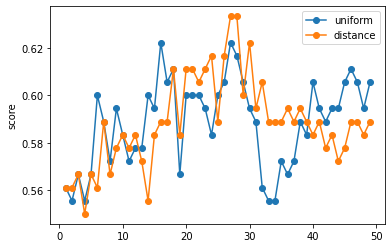

In [ ]:
from sklearn import neighbors
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np

cv = KFold(n_splits = 10, shuffle = False) #

# feature selection and transformation
X = train[selected_features + ['heart_disease_present'] ]
#y = train[]

for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,50):
       fold_accuracy = []
       knn = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
       # verificar cada uno de los modelos con validación cruzada.
       for train_fold, test_fold in cv.split(X):
          # División train test aleatoria
          f_train = X.loc[train_fold]
          f_test = X.loc[test_fold]
          # entrenamiento y ejecución del modelo
          knn.fit( X = f_train.drop(['heart_disease_present'], axis=1), 
                               y = f_train['heart_disease_present'])
          score = knn.score(f_test.drop(['heart_disease_present'], axis = 1), f_test['heart_disease_present'])
          fold_accuracy.append(score)
       total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
   plt.plot(range(1,len(total_scores)+1), total_scores, 
             marker='o', label=weights)
   print ('Max Value ' +  weights + " : " +  str(max(total_scores)) +" (" + str(np.argmax(total_scores) + 1) + ")")
   plt.ylabel('score')      
    

plt.legend()
plt.show() 


Ejecutamos el mejor modelo seleccionado con la parametrización elegida. 

Metrics 
              precision    recall  f1-score   support

           0       0.54      0.83      0.65        36
           1       0.62      0.28      0.38        36

    accuracy                           0.56        72
   macro avg       0.58      0.56      0.52        72
weighted avg       0.58      0.56      0.52        72

Confusion matrix, without normalization
[[30  6]
 [26 10]]


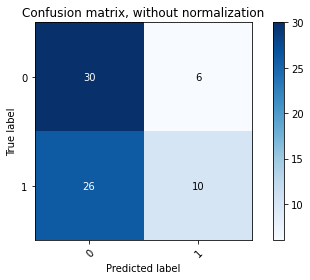

In [ ]:
n_neighbors = 27
weights = 'distance'
clf = neighbors.KNeighborsClassifier(n_neighbors= n_neighbors, weights=weights) 
# fit and predict
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
plot_confusion_matrix(y_test, y_pred , classes = unique_labels(y_test, y_pred), normalize=False)
